In [1]:
import pandas as pd
import strategy as s
import numpy as np

data=pd.read_csv('large_cap.csv')
data.drop('Date',axis='columns',inplace=True)
results=s.run(data,.2,s.getShortLongTupples(),np.arange(.005,.026,.005))
results

,short,long,alpha,strategy_returns,strategy_std,benchmark_returns,benchmark_std,training_strategy_returns,training_strategy_std,training_benchmark_returns,training_benchmark_std,ticker
0,12,50,0.005,0.000235,0.021691,0.001302,0.017774,0.001048,0.017313,0.000311,0.018389,AAPL
1,25,61,0.025,0.000064,0.019098,0.000803,0.017736,0.002504,0.015300,0.001477,0.015562,ABBV
2,23,50,0.020,0.000600,0.016564,0.000734,0.014808,0.001795,0.011553,0.000885,0.011031,ABT
3,18,83,0.020,0.000323,0.018477,0.000849,0.014732,0.001738,0.014400,0.000902,0.013483,ACN
4,20,55,0.005,0.000664,0.023157,0.001113,0.019205,0.004172,0.021169,0.001603,0.015621,ADBE
...,...,...,...,...,...,...,...,...,...,...,...,...
91,19,61,0.005,0.000844,0.017007,0.000839,0.015812,0.003266,0.011788,0.001458,0.013354,V
92,23,55,0.005,0.000270,0.012136,0.000304,0.011060,0.000882,0.010845,0.000676,0.010289,VZ
93,23,50,0.005,-0.000200,0.021206,0.000399,0.019192,0.002987,0.010467,0.000956,0.011669,WFC
94,20,61,0.005,-0.000268,0.015602,0.000490,0.012968,0.000364,0.008608,0.000540,0.009054,WMT


In [2]:
results.to_csv('correct_results.csv')

In [3]:
winners=results[results.strategy_returns>results.benchmark_returns]
losers=results[results.strategy_returns<results.benchmark_returns]
len(winners)/len(results)

0.09375

In [5]:
len(results[results.training_strategy_returns>results.training_benchmark_returns])/len(results)

0.96875

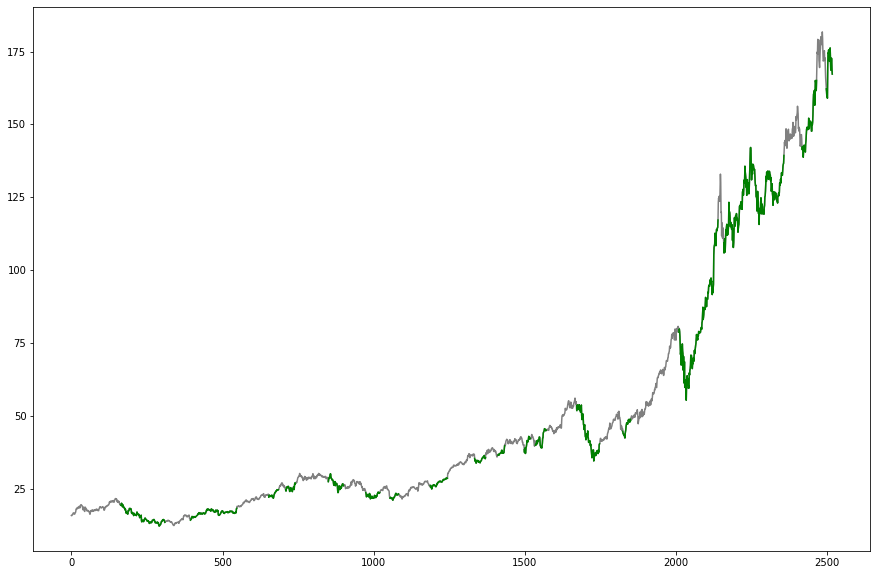

In [13]:
bt=s.backtest(data['AAPL'],20,100,.001)
s.plotPosition(bt)

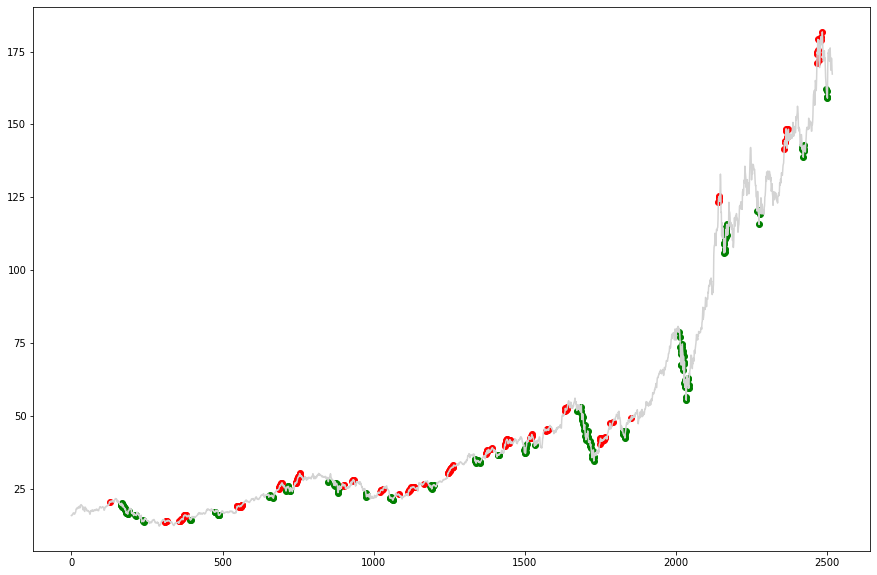

In [14]:
import matplotlib.pyplot as plt

buyIndeces=bt[bt.signal=='buy'].index
sellIndeces=bt[bt.signal=='sell'].index

plt.figure(figsize=(15,10))
plt.plot(bt.index,bt.price,color='lightgray')
plt.scatter(buyIndeces,bt.price[buyIndeces],color='green')
plt.scatter(sellIndeces,bt.price[sellIndeces],color='red')

In [15]:
len(bt[bt.signal!='-'])/len(bt)

0.1715647339158062

In [62]:
import scipy

def sigSignal(pSeries,short,long,p):
    df=pSeries.to_frame()
    df.columns=['price']
    df['returns']=df.price.pct_change()
    df['s_long']=df.returns.shift(short).rolling(long).std()
    df['s_short']=df.returns.rolling(short).std()
    chi_l=scipy.stats.chi2.ppf(p,long-1)
    df['sig_ceiling']=((long-1)*df['s_long']**2/chi_l)**.5
    df['signal']=np.where(df.s_short>df.sig_ceiling,True,False)
    return df

In [25]:
ss=sigSignal(data['AAPL'],20,100,.0001)

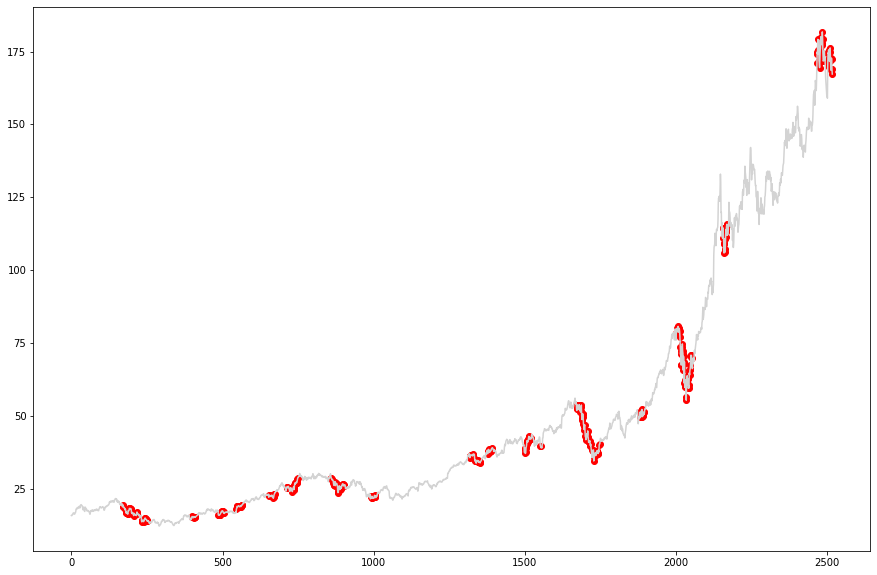

In [26]:
sIndex=ss[ss].index

plt.figure(figsize=(15,10))
plt.plot(bt.index,bt.price,color='lightgray')
plt.scatter(sIndex,bt.price[sIndex],color='red')

In [27]:
len(bt.signal)

2518

In [28]:
len(ss)

2518

In [39]:
sf=np.where((bt.signal=='buy') & ss,'buy',np.where((bt.signal=='sell') & ss,'sell','-'))

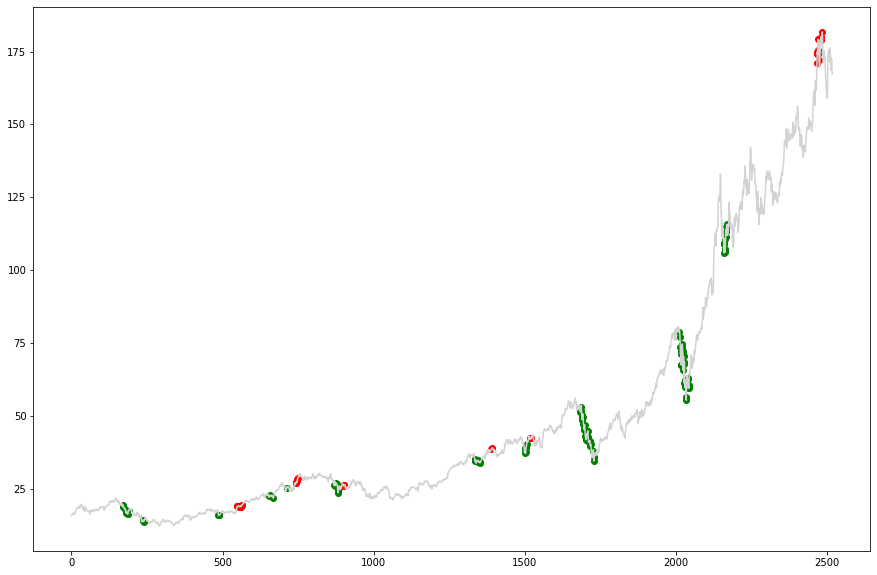

In [42]:
sfSeries=pd.Series(sf)
sBuy=sfSeries[sfSeries=='buy'].index
sSell=sfSeries[sfSeries=='sell'].index

plt.figure(figsize=(15,10))
plt.plot(bt.index,bt.price,color='lightgray')
plt.scatter(sBuy,bt.price[sBuy],color='green')
plt.scatter(sSell,bt.price[sSell],color='red')

In [49]:
newSignal=np.where((bt.signal.shift(1)=='buy') & (bt.signal=='-'),'buy','-')

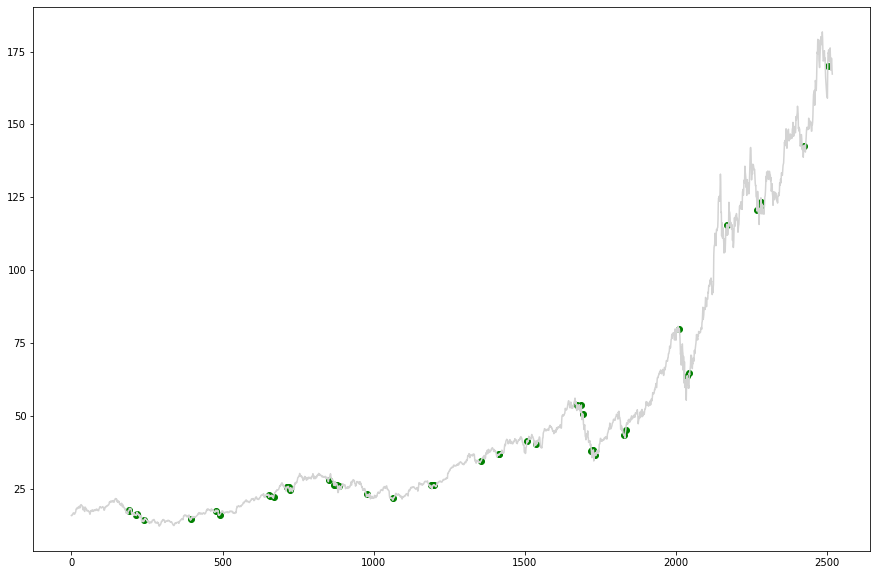

In [50]:
nss=pd.Series(newSignal)
nsi=nss[nss=='buy'].index

plt.figure(figsize=(15,10))
plt.plot(bt.index,bt.price,color='lightgray')
plt.scatter(nsi,bt.price[nsi],color='green')

In [53]:
latest=ss & (newSignal=='buy')

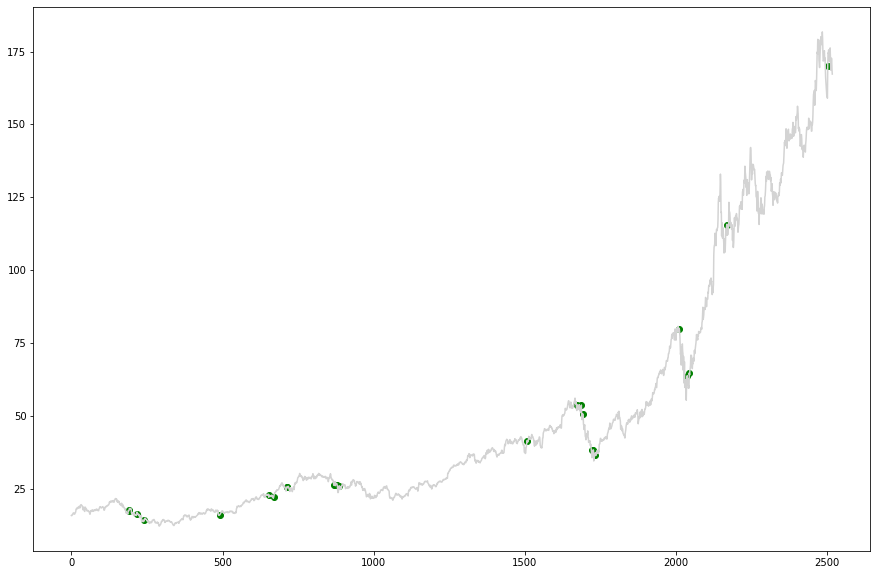

In [56]:
ls=pd.Series(latest)
lsi=ls[ls].index

plt.figure(figsize=(15,10))
plt.plot(bt.index,bt.price,color='lightgray')
plt.scatter(lsi,bt.price[lsi],color='green')

In [70]:
pSeries=data['XOM']
short=20
long=60
p=.001
alpha=.01

ss=sigSignal(pSeries,short,long,p)
bt=s.backtest(pSeries,short,long,alpha)

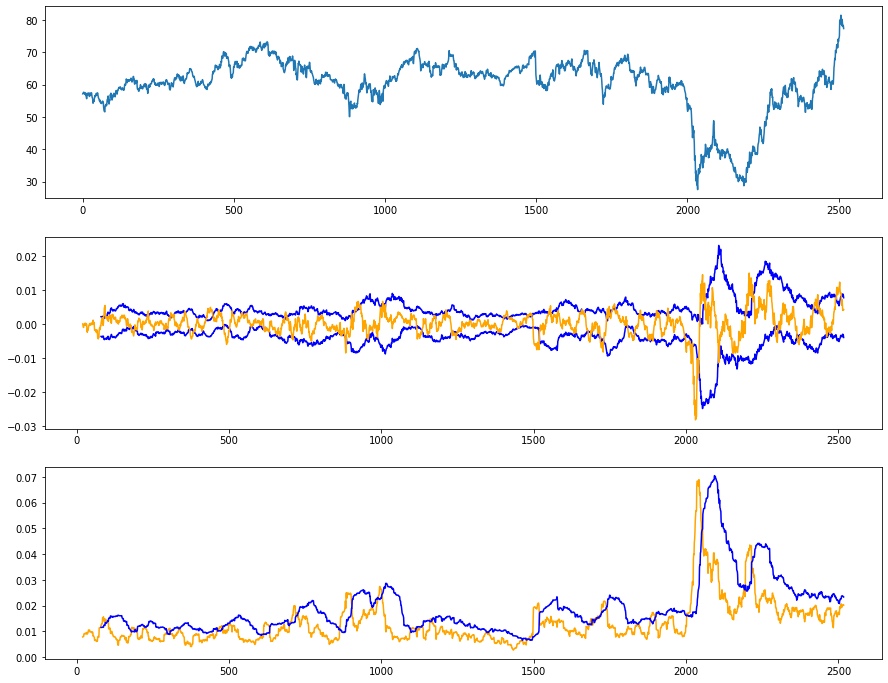

In [73]:
fig, (p1,p2,p3) = plt.subplots(3,figsize=(15,12))

p1.plot(bt.index,bt.price)
p2.plot(bt.index,bt.u_long+bt.E_long,color='blue')
p2.plot(bt.index,bt.u_long-bt.E_long,color='blue')
p2.plot(bt.index,bt.u_short,color='orange')
p3.plot(bt.index,ss.s_short,color='orange')
p3.plot(bt.index,ss.sig_ceiling,color='blue')

In [239]:
import scipy.stats as sciStats
import itertools as it

def error(sigma,n,p):
    return sciStats.t.ppf(1-p,n-1)*sigma/n**.5

def upperSignal(longMean,longStd,long,short,shortMean,p):
    upperBound=longMean+error(longStd,long,p)
    return {
        'p':p,
        'short':short,
        'long':long,
        'signal':shortMean>upperBound
    }

def lowerSignal(longMean,longStd,long,short,shortMean,p):
    lowerBound=longMean-error(longStd,long,p)
    return {
        'p':p,
        'short':short,
        'long':long,
        'signal':shortMean<lowerBound
    }

def buySellSignal(upperSignal,lowerSignal):
    sig=np.where(lowerSignal['signal'],'buy',np.where(upperSignal['signal'],'sell','-'))
    return {
        'signal':sig,
        'lower_p':lowerSignal['p'],
        'lower_short':lowerSignal['short'],
        'lower_long':lowerSignal['long'],
        'upper_p':upperSignal['p'],
        'upper_short':upperSignal['short'],
        'upper_long':upperSignal['long']
    }

def getPosition(signal):
    pos=['bought'] if signal[0]=='buy' else ['-']

    for i in range(1,len(signal)):
        if signal[i]=='buy':
            pos.append('bought')
        elif pos[i-1]=='bought' and signal[i]!='sell':
            pos.append('bought')
        else:
            pos.append('-')
            
    return pd.Series(pos)

def getSignals(returns,shortRange,longRange,upperPRange,lowerPRange):
    upperSignals=[]
    lowerSignals=[]
    for short in shortRange:
        shortMean=returns.rolling(short).mean()
        
        for long in longRange:
            window=returns.shift(short).rolling(long)
            longMean=window.mean()
            longStd=window.std()
            
            upperSignals=upperSignals+[upperSignal(longMean,longStd,long,short,shortMean,p) for p in upperPRange]
            lowerSignals=lowerSignals+[lowerSignal(longMean,longStd,long,short,shortMean,p) for p in lowerPRange]
            
    return lowerSignals, upperSignals

def train(trainingSet,buySellSignals):
    index=len(trainingSet)
    rows=[]
    for sig in buySellSignals:
        position=getPosition(sig['signal'][:index])
        rows.append({
            'returns':trainingSet[position=='bought'].mean(),
            'upper_short':sig['upper_short'],
            'upper_long':sig['upper_long'],
            'upper_p':sig['upper_p'],
            'lower_short':sig['lower_short'],
            'lower_long':sig['lower_long'],
            'lower_p':sig['lower_p'],
            'signal':sig['signal']
        })
    df=pd.DataFrame(rows)
    return df
#     winner=df.sort_values('returns',ascending=False).iloc[0]
#     return {
#         'returns':trainingSet[position=='bought'].mean(),
#         'benchmark_returns':trainingSet.mean(),
#         'benchmark_std':trainingSet.std(),
#         'upper_short':sig.upper_short,
#         'upper_long':sig.upper_long,
#         'upper_p':sig.upper_p,
#         'lower_short':sig.lower_short,
#         'lower_long':sig.lower_short,
#         'lower_p':sig.lower_p,
#         'signal':winner.signal
#     }

def strategy(pSeries,trainingSize,shortRange,longRange,upperPRange,lowerPRange):
    returns=pSeries.pct_change()
    lowerSignals, upperSignals=getSignals(returns,shortRange,longRange,upperPRange,lowerPRange)
    buySellSignals=[buySellSignal(lower,upper) for lower,upper in it.product(lowerSignals,upperSignals)]
    
    trainingCutoff=int(len(pSeries)*trainingSize)
    trainingSet=returns[:trainingCutoff]
    testSet=returns[trainingCutoff:]
    
    trainingOutcome=train(trainingSet,buySellSignals)
    position=getPosition(trainingOutcome['signal'][trainingCutoff:])
    
    return {
        'short':trainingOutcome['short'],
        'long':trainingOutcome['long'],
        'lower_p':trainingOutcome['lower_p'],
        'upper_p':trainingOutcome['upper_p'],
        'training_returns':trainingOutcome['returns'],
        'training_benchmark_returns':trainingOutcome['benchmark_returns'],
        'training_benchmark_std':trainingOutcome['benchmark_std'],
        'returns':testSet[position=='bought'].mean(),
        'benchmark_returns':testSet.mean(),
        'benchmark_std':testSet.std()
    }

In [238]:
pSeries=data['XOM']
longRange=np.linspace(50,100,10,dtype=int)
shortRange=(longRange/4).astype(int)
lowerPRange=np.linspace(.0000001,.0001,5)
upperPRange=np.linspace(.01,.06,5)

results=strategy(pSeries,.2,shortRange,longRange,lowerPRange,upperPRange)

AttributeError: 'dict' object has no attribute 'upper_short'

In [240]:
%%time

returns=pSeries.pct_change()
lowerSignals, upperSignals=getSignals(returns,shortRange,longRange,upperPRange,lowerPRange)
buySellSignals=[buySellSignal(lower,upper) for lower,upper in it.product(lowerSignals,upperSignals)]

trainingCutoff=int(len(pSeries)*trainingSize)
trainingSet=returns[:trainingCutoff]
testSet=returns[trainingCutoff:]

trainingOutcome=train(trainingSet,buySellSignals)

CPU times: user 3min 46s, sys: 12.1 s, total: 3min 58s
Wall time: 4min 8s


In [246]:
bs=trainingOutcome.sort_values('returns',ascending=False).iloc[0].signal

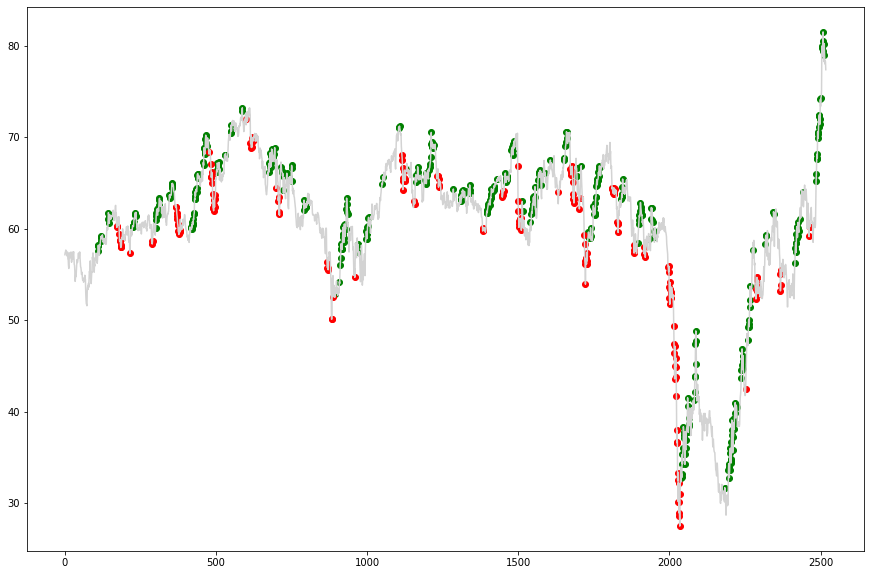

In [252]:
plt.figure(figsize=(15,10))
plt.plot(pSeries,color='lightgrey')
plt.scatter(pSeries.index[bs=='buy'],pSeries[bs=='buy'],color='green')
plt.scatter(pSeries.index[bs=='sell'],pSeries[bs=='sell'],color='red')

In [229]:
u=upperSignals[0]['signal']
u

0       False
1       False
2       False
3       False
4       False
        ...  
2513    False
2514    False
2515    False
2516    False
2517    False
Name: XOM, Length: 2518, dtype: bool

In [232]:
x=np.where(l,'buy',np.where(u,'sell','-'))
y=pd.Series(x)

In [234]:
len(y[y=='sell'])

322

In [210]:
rows=[]
for x in buySellSignals:
#     rows.append({
#         'short':x['upper_short'],
#         'long':x['upper_long'],
#         'p':x['upper_p'],
#         'sell_n':len(x['signal'][x['signal']=='sell'])
#     })
    rows.append({
        'short':x['lower_short'],
        'long':x['lower_long'],
        'p':x['lower_p'],
        'buy_n':len(x['signal'][x['signal']=='buy'])
    })
df=pd.DataFrame(rows)
df

,short,long,p,buy_n
0,12,50,0.0100,322
1,12,50,0.0225,403
2,12,50,0.0350,481
3,12,50,0.0475,530
4,12,50,0.0600,566
...,...,...,...,...
249995,25,100,0.0100,340
249996,25,100,0.0225,417
249997,25,100,0.0350,466
249998,25,100,0.0475,518


In [223]:
[len(sig[sig]) for sig in [s['signal'] for s in lowerSignals]]

[45,
 103,
 123,
 131,
 143,
 51,
 124,
 136,
 153,
 165,
 62,
 141,
 157,
 173,
 184,
 72,
 163,
 177,
 188,
 192,
 89,
 162,
 177,
 189,
 203,
 92,
 169,
 184,
 192,
 196,
 98,
 177,
 200,
 210,
 222,
 100,
 188,
 202,
 209,
 219,
 112,
 196,
 212,
 222,
 231,
 114,
 204,
 219,
 231,
 242,
 46,
 95,
 115,
 126,
 133,
 52,
 116,
 133,
 142,
 151,
 61,
 131,
 148,
 160,
 167,
 65,
 150,
 166,
 175,
 182,
 80,
 160,
 169,
 179,
 185,
 87,
 164,
 175,
 183,
 192,
 84,
 171,
 184,
 194,
 200,
 90,
 179,
 190,
 203,
 206,
 102,
 185,
 201,
 215,
 224,
 110,
 191,
 207,
 222,
 232,
 35,
 95,
 101,
 108,
 118,
 43,
 107,
 116,
 124,
 135,
 56,
 115,
 128,
 136,
 144,
 64,
 125,
 139,
 151,
 157,
 79,
 137,
 147,
 161,
 168,
 75,
 141,
 153,
 160,
 172,
 77,
 148,
 157,
 169,
 177,
 86,
 151,
 166,
 178,
 185,
 91,
 157,
 169,
 183,
 193,
 97,
 171,
 187,
 194,
 202,
 32,
 87,
 99,
 110,
 119,
 38,
 102,
 114,
 125,
 128,
 53,
 118,
 126,
 135,
 142,
 64,
 130,
 141,
 148,
 152,
 78,
 131,
 1

In [224]:
[len(sig[sig]) for sig in [s['signal'] for s in upperSignals]]

[322,
 403,
 481,
 530,
 566,
 348,
 431,
 485,
 545,
 583,
 377,
 474,
 536,
 569,
 609,
 408,
 499,
 561,
 600,
 633,
 431,
 517,
 573,
 617,
 645,
 446,
 514,
 574,
 615,
 646,
 455,
 523,
 585,
 616,
 657,
 464,
 539,
 589,
 637,
 670,
 469,
 565,
 605,
 643,
 672,
 487,
 566,
 615,
 653,
 690,
 309,
 403,
 458,
 511,
 556,
 331,
 418,
 481,
 524,
 563,
 368,
 455,
 505,
 554,
 589,
 386,
 471,
 542,
 577,
 618,
 401,
 480,
 544,
 587,
 632,
 413,
 496,
 552,
 600,
 646,
 430,
 518,
 563,
 602,
 632,
 441,
 520,
 573,
 612,
 642,
 460,
 526,
 580,
 634,
 663,
 475,
 534,
 593,
 622,
 666,
 287,
 370,
 443,
 493,
 531,
 316,
 409,
 462,
 513,
 545,
 347,
 444,
 501,
 537,
 570,
 363,
 465,
 508,
 549,
 589,
 380,
 460,
 516,
 546,
 586,
 381,
 467,
 512,
 559,
 595,
 391,
 484,
 536,
 577,
 611,
 414,
 496,
 546,
 583,
 616,
 422,
 505,
 556,
 601,
 638,
 437,
 516,
 579,
 617,
 655,
 277,
 372,
 437,
 488,
 521,
 306,
 388,
 449,
 494,
 534,
 329,
 425,
 482,
 524,
 566,
 358,
 443

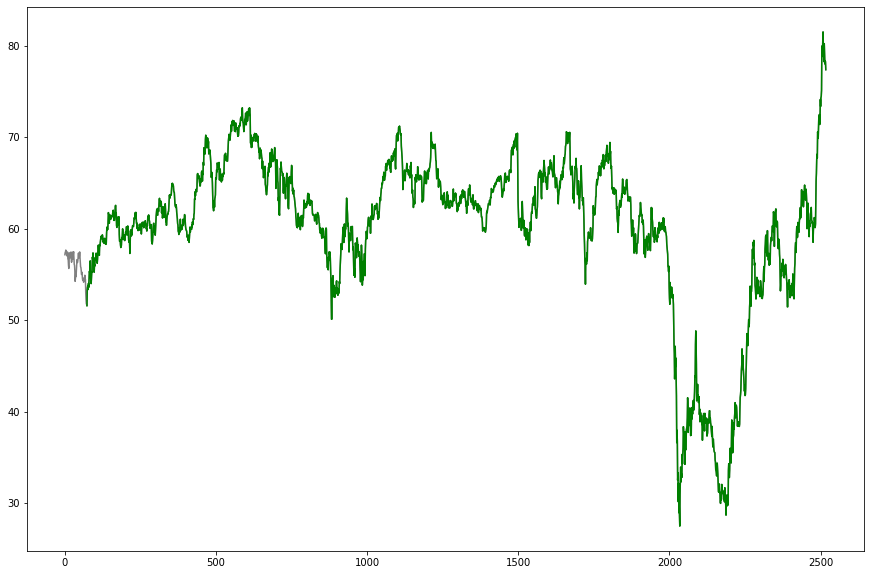

In [205]:
# position=s.getPosition(trainingOutcome['signal'])
# posSeries=np.where(position=='bought',pSeries,float('nan'))
plt.figure(figsize=(15,10))
plt.plot(pSeries,color='grey')
# plt.plot(posSeries,color='green')
plt.scatter()

In [194]:
sig=trainingOutcome['signal']
len(sig[sig=='buy'])


2445

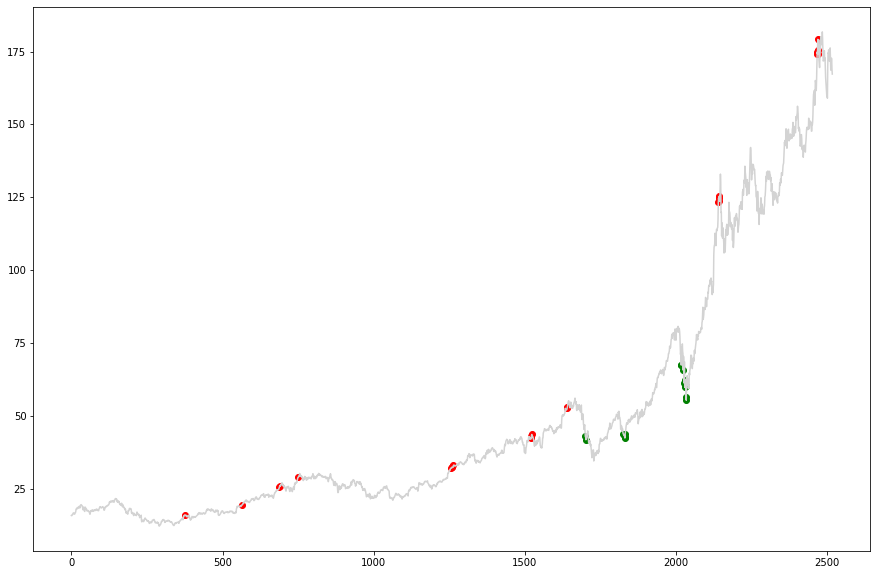

In [117]:
plt.figure(figsize=(15,10))

plt.plot(pSeries,color='lightgray')
plt.scatter(pSeries.index[underValued],pSeries[underValued],color='green')
plt.scatter(pSeries.index[overValued],pSeries[overValued],color='red')

In [101]:
sample=data.iloc[:,:15]
res=s.run(sample,.2,s.getShortLongTupples(),[.0000001])
res

,short,long,alpha,strategy_returns,strategy_std,benchmark_returns,benchmark_std,training_strategy_returns,training_strategy_std,training_benchmark_returns,training_benchmark_std,ticker
0,19,61,1.000000e-07,0.001899,0.021553,0.001302,0.017774,0.000241,0.018761,0.000311,0.018389,AAPL
1,20,100,1.000000e-07,0.001273,0.019690,0.000803,0.017736,0.012407,0.021618,0.001477,0.015562,ABBV
2,15,88,1.000000e-07,0.000503,0.016476,0.000734,0.014808,0.001949,0.009889,0.000885,0.011031,ABT
3,12,61,1.000000e-07,0.000982,0.016055,0.000849,0.014732,0.001630,0.010526,0.000902,0.013483,ACN
4,16,88,1.000000e-07,0.001084,0.020393,0.001113,0.019205,0.002805,0.015870,0.001603,0.015621,ADBE
5,12,50,1.000000e-07,0.002541,0.037169,0.001314,0.024087,NaN,NaN,0.001024,0.015073,AMAT
6,22,50,1.000000e-07,0.003551,0.040044,0.002382,0.037319,0.011056,0.017067,-0.000788,0.033377,AMD
7,12,72,1.000000e-07,0.000483,0.018213,0.000522,0.016071,0.003381,0.013107,0.001408,0.014624,AMGN
8,15,66,1.000000e-07,0.001265,0.019190,0.001266,0.019353,0.001942,0.017791,0.001473,0.018768,AMZN
9,15,100,1.000000e-07,0.001046,0.027381,0.001241,0.020739,0.001976,0.017553,0.002020,0.022185,ASML


In [103]:
winners=res[res.strategy_returns>res.benchmark_returns]
len(winners)/len(res)

0.4666666666666667

In [104]:
len(res[res.training_strategy_returns>res.training_benchmark_returns])

12

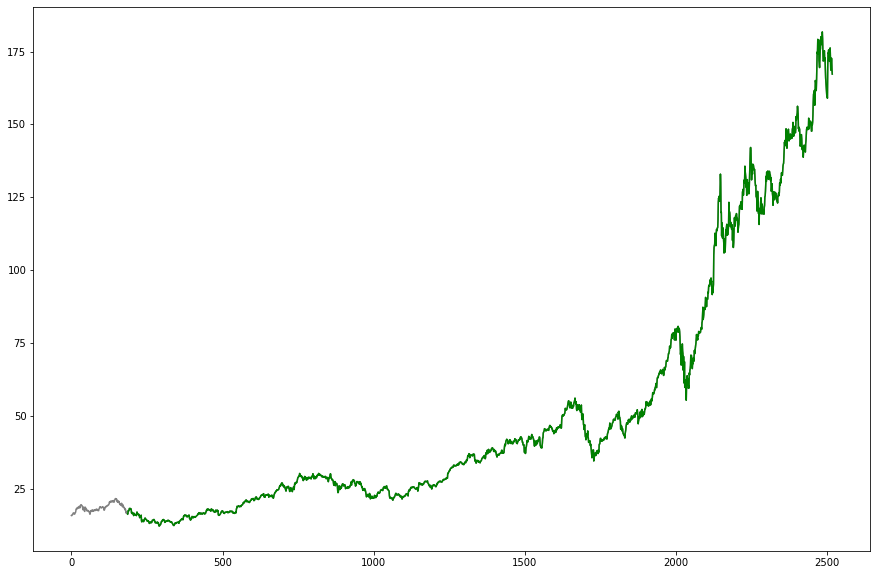

In [108]:
bt=s.backtest(data['AAPL'],19,61,.0000001)
s.plotPosition(bt)

In [119]:
np.linspace(.0000001,.0001,5)

array([1.0000e-07, 2.5075e-05, 5.0050e-05, 7.5025e-05, 1.0000e-04])

In [126]:
import itertools as it

list(itertools.product([1,2],[list(tupple) for tupple in itertools.product([3,4],[5,6])]))

[(1, [3, 5]),
 (1, [3, 6]),
 (1, [4, 5]),
 (1, [4, 6]),
 (2, [3, 5]),
 (2, [3, 6]),
 (2, [4, 5]),
 (2, [4, 6])]

In [127]:
list(it.product([1,2],[3,4],[5,6]))

[(1, 3, 5),
 (1, 3, 6),
 (1, 4, 5),
 (1, 4, 6),
 (2, 3, 5),
 (2, 3, 6),
 (2, 4, 5),
 (2, 4, 6)]

In [129]:
x=pd.Series(np.ones(3),name='penis')

In [130]:
x.name

'penis'